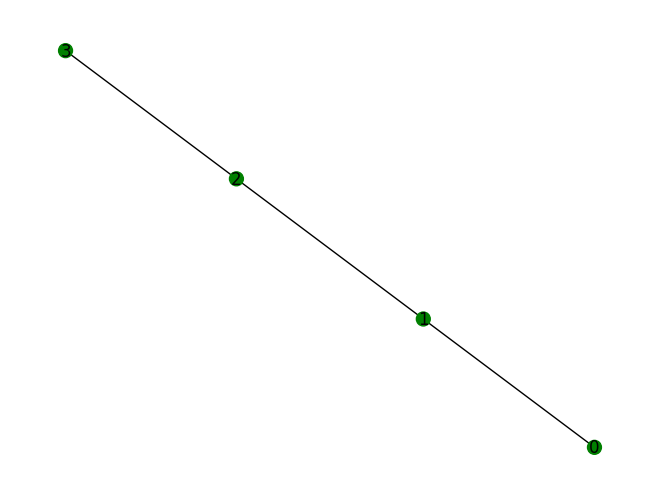

In [1]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume  
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, random_coupling

import pickle

num_qubits = 16

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

num_qubits = circuit.num_qubits

circuit = transpile(circuit, basis_gates = ['cp', 'u'])

num_partitions = 4


qpu_sizes = [int(num_qubits/num_partitions)+1]*num_partitions

coupling = [[i, i+1] for i in range(num_partitions-1)]

network = QuantumNetwork(qpu_sizes, coupling)

network.draw()



In [2]:
graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network=network, num_qubits=num_qubits, depth=graph.depth)

from disqco.parti.FM.FM_methods import get_all_configs, get_all_costs_hetero

if num_partitions <=10:

    configs = get_all_configs(num_partitions, hetero=True)

    costs, edge_tree = get_all_costs_hetero(network, configs)
else:

    costs = {}

print(costs)

{((0, 0, 0, 1), (0, 0, 0, 1)): 0, ((0, 0, 0, 1), (0, 0, 1, 0)): 1, ((0, 0, 0, 1), (1, 0, 1, 1)): 3, ((0, 0, 0, 1), (0, 1, 0, 0)): 2, ((0, 0, 0, 1), (0, 1, 1, 0)): 2, ((0, 0, 0, 1), (1, 0, 0, 0)): 3, ((0, 0, 0, 1), (0, 0, 1, 1)): 1, ((0, 0, 0, 1), (0, 1, 0, 1)): 2, ((0, 0, 0, 1), (0, 1, 1, 1)): 2, ((0, 0, 0, 1), (1, 1, 0, 0)): 3, ((0, 0, 0, 1), (1, 1, 1, 0)): 3, ((0, 0, 0, 1), (1, 0, 1, 0)): 3, ((0, 0, 0, 1), (1, 0, 0, 1)): 3, ((0, 0, 0, 1), (1, 1, 0, 1)): 3, ((0, 0, 0, 1), (1, 1, 1, 1)): 3, ((0, 0, 1, 0), (0, 0, 0, 1)): 1, ((0, 0, 1, 0), (0, 0, 1, 0)): 0, ((0, 0, 1, 0), (1, 0, 1, 1)): 3, ((0, 0, 1, 0), (0, 1, 0, 0)): 1, ((0, 0, 1, 0), (0, 1, 1, 0)): 1, ((0, 0, 1, 0), (1, 0, 0, 0)): 2, ((0, 0, 1, 0), (0, 0, 1, 1)): 1, ((0, 0, 1, 0), (0, 1, 0, 1)): 2, ((0, 0, 1, 0), (0, 1, 1, 1)): 2, ((0, 0, 1, 0), (1, 1, 0, 0)): 2, ((0, 0, 1, 0), (1, 1, 1, 0)): 2, ((0, 0, 1, 0), (1, 0, 1, 0)): 2, ((0, 0, 1, 0), (1, 0, 0, 1)): 3, ((0, 0, 1, 0), (1, 1, 0, 1)): 3, ((0, 0, 1, 0), (1, 1, 1, 1)): 3, ((1, 0, 1

In [3]:
from disqco.parti.FM.FM_hetero import run_FM_hetero

final_cost, final_assignment, cost_list = run_FM_hetero(hypergraph=graph,
                                                        initial_assignment=assignment,
                                                        qpu_info=qpu_sizes,
                                                        num_partitions=num_partitions,
                                                        network=network,
                                                        limit=num_qubits,
                                                        costs={},
                                                        passes=50,
                                                        log=True)





Initial cost: 49
All passes complete.
Final cost: 43


In [4]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.drawing.mpl_drawing import draw_graph_mpl

%load_ext jupyter_tikz

# if num_qubits <= 32:
#     draw_graph_tikz(graph, assignment, qpu_sizes)
# else:
#     if num_qubits <= 64:
#         draw_graph_mpl(graph, assignment, qpu_sizes)

In [5]:
# print("Final cost: ", final_cost)
import qiskit
qiskit.__version__

'1.2.4'

In [6]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero

print(qpu_sizes)

final_assignment_list, final_cost_list, _ = MLFM_recursive_hetero(graph,
                                                                    assignment,
                                                                    qpu_sizes,
                                                                    limit=num_qubits,
                                                                    network=network,
                                                                    log=True,
                                                                    stochastic=True,
                                                                    costs=costs, 
                                                                    level_limit=None)





[5, 5, 5, 5]
Initial cost: 49
All passes complete.
Final cost: 29
Best cost at level 0: 29
Initial cost: 29
All passes complete.
Final cost: 29
Best cost at level 1: 29
Initial cost: 29
All passes complete.
Final cost: 29
Best cost at level 2: 29
Initial cost: 29
All passes complete.
Final cost: 29
Best cost at level 3: 29
Initial cost: 29
All passes complete.
Final cost: 29
Best cost at level 4: 29


In [7]:

import numpy as np

final_assignment = final_assignment_list[np.argmin(final_cost_list)]

counts = []

for layer in final_assignment:
    counts.append(np.bincount(layer))
    print(layer)

print(counts)
# if num_qubits <= 32:
#     fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
#     display(fig)
# else:
#      draw_graph_mpl(graph, final_assignment, qpu_sizes)

[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[3 2 1 3 0 1 3 1 2 2 3 2 3 1 1 2]
[array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5]), array([1, 5, 5, 5])]


In [8]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive

list_of_assignments, list_of_costs, _ = MLFM_recursive(
    graph,
    assignment,
    qpu_sizes,
    limit='qubit',
    log=True)

from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
import numpy as np

best_assignment = list_of_assignments[np.argmin(list_of_costs)]
print("best assignment", best_assignment)
cost_hetero = calculate_full_cost_hetero(graph, best_assignment, num_partitions, costs, network)

print(cost_hetero)

Initial cost: 39
All passes complete.
Final cost: 26
Best cost at level 0: 26
Initial cost: 26
All passes complete.
Final cost: 25
Best cost at level 1: 25
Initial cost: 25
All passes complete.
Final cost: 25
Best cost at level 2: 25
Initial cost: 25
All passes complete.
Final cost: 26
Best cost at level 3: 25
Initial cost: 25
All passes complete.
Final cost: 25
Best cost at level 4: 25
best assignment [[0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 0 0 2 3 1 1 1 2 0]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]
 [0 1 1 2 2 0 2 1 0 0 3 1 0 1 2 2]]
37


In [9]:
from disqco.utils.qiskit_to_op_list import circuit_to_gate_layers
layers = circuit_to_gate_layers(circuit)

for layer in layers:
    for gate in layer:
        print(gate)
        # print(gate.qargs)
        # print(gate.op.name)
        # print(gate.op.params)
        # print(gate.op.to_dict())
        # print(gate.op.to_matrix())
        # print(gate.op.to_instruction())
        # print(gate.op.to_gate())
        # print(gate.op.to_circuit())

['u', [0], ['q'], [1.6348004668381841, 2.9252288274438545, 1.6722279273671319]]
['u', [1], ['q'], [4.761329095612511, 0.9900842374586134, 0.3920829391778108]]
['u', [3], ['q'], [0.19757829551199677, 1.1653278673545326, -2.7769715877770746]]
['cp', [4, 2], ['q', 'q'], [5.4042698507693325]]
['u', [5], ['q'], [1.963078267992027, -2.076234364620666, -2.399344241521905]]
['u', [6], ['q'], [1.1560752595069541, -1.8387134231675626, 1.2466148889906696]]
['u', [7], ['q'], [6.1717531088236735, 3.135174112161575, 1.8980360946748234]]
['u', [9], ['q'], [3.6158870554721747, 1.4129730207561022, 0.9585969534130987]]
['u', [11], ['q'], [4.948463805751491, 6.240459710334712, 1.9195179441111367]]
['cp', [8, 12], ['q', 'q'], [3.438078813890603]]
['u', [13], ['q'], [6.057696957908057, 1.3233174744169163, 3.291880229764506]]
['u', [14], ['q'], [0.5601404490451607, 2.097435257088108, -2.9989933302791085]]
['cp', [10, 15], ['q', 'q'], [1.9867966845796508]]
['cp', [6, 0], ['q', 'q'], [0.412472828469539]]
['cp